# Super resolución de una imagen de 14x14 a 28x28

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from sklearn.decomposition import PCA

## 1. Cargar los datos normalizados y como tensores.

In [3]:
normalize_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [4]:
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=normalize_transform)
mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=normalize_transform)

train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=2000, shuffle=True)
valid_loader = torch.utils.data.DataLoader(mnist_data_valid, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 90331120.62it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23166130.01it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30627851.57it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18585881.72it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 2. Creación de la arquitectura del autoencoder.

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1), # -> N x 64 x 14 x 14
            nn.Tanh(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1), # N x 128 x 14 x 14
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1, output_padding=0), # N -> 64 x 14 x 14
            nn.Tanh(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1), # N -> 1 x 28 x 28
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## 3. Entrenamiento.

### 3.1. Configuración del dispositivo y modelo.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 3.2. Entrenamiento.

La similitud coseno se utiliza para calcular la pérdida (loss) entre la imagen original (img) y la imagen reconstruida (pred) en el contexto de un entrenamiento de un modelo de autoencoder.

La similitud coseno es una medida de similitud que mide el coseno del ángulo entre dos vectores. En este caso, los vectores son las representaciones aplanadas de las imágenes originales (img_flatten) y las imágenes reconstruidas (pred_flatten).

In [31]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    training_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        img_resized = F.interpolate(img, size=(14, 14), mode='bicubic', align_corners=False)

        optimizer.zero_grad()
        pred = model(img_resized)

        img_flatten = img.view(img.size(0), -1)
        pred_flatten = pred.view(pred.size(0), -1)

        loss = 1 - F.cosine_similarity(img_flatten, pred_flatten).mean()

        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    average_loss = training_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f}")

Epoch [1/10] - Loss: 0.0062
Epoch [2/10] - Loss: 0.0061
Epoch [3/10] - Loss: 0.0059
Epoch [4/10] - Loss: 0.0058
Epoch [5/10] - Loss: 0.0056
Epoch [6/10] - Loss: 0.0055
Epoch [7/10] - Loss: 0.0054
Epoch [8/10] - Loss: 0.0053
Epoch [9/10] - Loss: 0.0053
Epoch [10/10] - Loss: 0.0052


## 4. Guardar el modelo.

In [10]:
torch.save(model, './modelos/autoencoder_14_28.pth')

## 5. Visualización de un ejemplo.

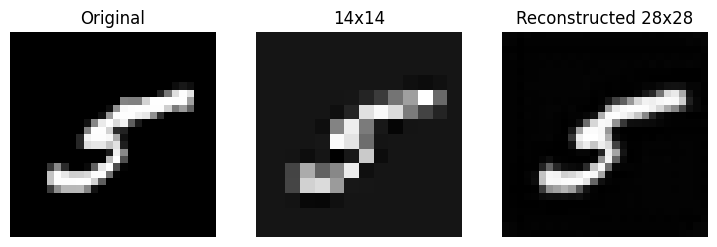

In [32]:
model.eval()

images, _ = next(iter(train_loader))

original_image = images[0].unsqueeze(0).to(device)
resized_image = F.interpolate(original_image, size=(14, 14), mode='bicubic', align_corners=False)

with torch.no_grad():
    reconstructed_image = model(resized_image)

original_image_np = original_image.cpu().squeeze().numpy()
resized_image_np = resized_image.cpu().squeeze().numpy()
reconstructed_image_np = reconstructed_image.cpu().squeeze().numpy()

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.imshow(original_image_np, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(resized_image_np, cmap='gray')
plt.title('14x14')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image_np, cmap='gray')
plt.title('Reconstructed 28x28')
plt.axis('off')

plt.show()

## 6. Medidas del rendimiento del modelo.

### 6.1. PSNR (Peak Signal-to-Noise Ratio).
Medir la calidad de una imagen comprimida o restaurada en comparación con la imagen original.

$PSNR = 10 \cdot \log_{10}\left(\frac{MSE}{M^2}\right)$

Donde:
- MSE (Mean Squared Error): El error cuadrático medio que representa la diferencia promedio al cuadrado entre los valores de los píxeles de la imagen original y la imagen reconstruida o procesada.
- $M^2$: M representa el valor máximo que puede tener un píxel en la imagen. Usualmente, en imágenes de 8 bits, M es igual a 255. Elevar M al cuadrado (M^2) se utiliza en la métrica para normalizar el MSE y escalarlo en función del rango dinámico de los valores de píxeles en la imagen. Esta normalización es necesaria para que el PSNR tenga sentido en decibelios.

In [12]:
model.eval()

psnr_values = []
for val_data in valid_loader:
    inputs = val_data[0].to(device)
    resized_image = F.interpolate(inputs, size=(14, 14), mode='bicubic', align_corners=False)

    with torch.no_grad():
        outputs = model(resized_image)

    inputs = inputs.cpu().numpy()
    outputs = outputs.cpu().numpy()

    mse = mean_squared_error(inputs.flatten(), outputs.flatten())
    psnr = 20 * np.log10(255.0 / np.sqrt(mse))

    psnr_values.append(psnr)

average_psnr = np.mean(psnr_values)

print(f"PSNR promedio: {average_psnr:.2f} dB")

PSNR promedio: 67.54 dB


En este caso, un PSNR promedio de 67.54 dB es un valor bastante alto y generalmente se considera indicativo de una muy buena calidad de imagen. Cuanto mayor sea el valor del PSNR, mejor será la calidad de la imagen en términos de la relación entre la señal (la información importante de la imagen) y el ruido (las discrepancias o errores de la imagen).


## 6.2. SSIM (Structural Similarity Index Measure).
Esta métrica se enfoca en medir la similitud estructural entre dos imágenes. Es útil para capturar cambios en textura y estructura, no solo en intensidad de píxeles.

$SSIM(x, y) = \frac{{(2 \cdot \mu_x \cdot \mu_y + C_1) \cdot (2 \cdot \sigma_{xy} + C_2)}}{{(\mu_x^2 + \mu_y^2 + C_1) \cdot (\sigma_x^2 + \sigma_y^2 + C_2)}}$

Donde:
- $x$ e $y$ son las dos imágenes que se están comparando.
- $\mu_x$ y $\mu_y$ son las medias locales de las imágenes $x$ e $y$ respectivamente.
- $\sigma_x$ y $\sigma_y$ son las desviaciones estándar locales de las imágenes $x$ e $y$ respectivamente.
- $\sigma_{xy}$ es la covarianza local entre $x$ e $y$.
- $C_1$ y $C_2$ son constantes pequeñas que se utilizan para evitar la indeterminación cuando las variables en el denominador son muy pequeñas.

In [13]:
ssim_scores = []

with torch.no_grad():
    for batch_data in valid_loader:
        inputs = batch_data[0].to(device)
        inputs_resized = F.interpolate(inputs, size=(14, 14), mode='bicubic', align_corners=False)

        with torch.no_grad():
            outputs = model(inputs_resized)

        inputs = inputs.cpu().numpy()
        outputs = outputs.cpu().numpy()

        for i in range(inputs.shape[0]):
            inputs[i] = np.clip(inputs[i], 0, 1)
            outputs[i] = np.clip(outputs[i], 0, 1)
            ssim_score = ssim(inputs[i, 0],outputs[i, 0],data_range=1)

            ssim_scores.append(ssim_score)

average_ssim = sum(ssim_scores) / len(ssim_scores)
print(f"SSIM promedio: {average_ssim:.4f}")

SSIM promedio: 0.9445


Un SSIM promedio de 0.9445 indica que, en promedio, las imágenes generadas son estructuralmente similares a las imágenes originales. Esto significa que las imágenes generadas mantienen la estructura y las características importantes de las imágenes originales.

## 6.3. MAE (Mean Absolute Error).

A diferencia de MSE, MAE proporciona un error medio absoluto entre la imagen reconstruida y la original, lo que puede ser más interpretable en ciertos contextos.

$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$

Donde:
- $n$ es el número total de observaciones o muestras.
- $y_i$ son las imágenes reales.
- $\hat{y_i}$ son las imágenes predichas por el modelo.

In [14]:
mae_scores = []

with torch.no_grad():
    for batch_data in valid_loader:
        inputs = batch_data[0].to(device)
        inputs_resized = F.interpolate(inputs, size=(14, 14))

        reconstructed_outputs = model(inputs_resized)

        mae = F.l1_loss(reconstructed_outputs, inputs, reduction='mean').item()
        mae_scores.append(mae)

average_mae = sum(mae_scores) / len(mae_scores)
print(f"MAE promedio: {average_mae:.4f}")

MAE promedio: 0.1276


Un MAE promedio de 0.1276 indica que, en promedio, las imágenes generadas por tu autoencoder de superresolución tienen una diferencia perceptual moderada en la intensidad de los píxeles en comparación con las imágenes originales.

## 6.4. Histogramas de Intensidades.

Comparar los histogramas de intensidades de píxeles entre las imágenes originales y las reconstruidas puede ofrecer una visión cualitativa de cómo el autoencoder está manejando las diferentes intensidades en la imagen. Por tanto, se ha escogido una imagen aleatoria para mostrar su histograma de densidad.

In [17]:
random_index = np.random.randint(len(valid_loader))
for i, batch_data in enumerate(valid_loader):
    if i == random_index:
        sample_data = batch_data[0].to(device)
        resized_data = F.interpolate(sample_data, size=(14, 14), mode='bicubic', align_corners=False)
        break

with torch.no_grad():
    reconstructed_sample = model(resized_data)

sample_data = sample_data.cpu().numpy()
reconstructed_sample = reconstructed_sample.cpu().numpy()

original_histogram = np.histogram(sample_data[0, 0], bins=256, range=(0, 1))
reconstructed_histogram = np.histogram(reconstructed_sample[0, 0], bins=256, range=(0, 1))

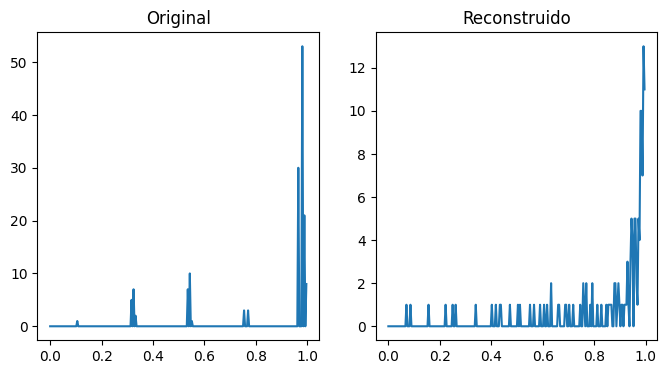

In [18]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("Original")
plt.plot(original_histogram[1][:-1], original_histogram[0])

plt.subplot(122)
plt.title("Reconstruido")
plt.plot(reconstructed_histogram[1][:-1], reconstructed_histogram[0])

plt.show()

El histograma reconstruido contiene más ruido de lo esperado ya que al hacer super resolución los pixeles se distorsionan.

## 6.5. Representar el espacio latente con PCA.

In [19]:
def get_latent_representations(data_loader, model, device):
    model.eval()
    latent_representations = []
    labels = []

    with torch.no_grad():
        for batch_data in data_loader:
            inputs = batch_data[0].to(device)
            inputs_resized = F.interpolate(inputs, size=(14, 14))

            encoded = model.encoder(inputs_resized)
            latent_representations.append(encoded.cpu().numpy())
            labels.append(batch_data[1].cpu().numpy())

    latent_representations = np.concatenate(latent_representations, axis=0)
    labels = np.concatenate(labels, axis=0)

    return latent_representations, labels

In [33]:
latent_representations, labels = get_latent_representations(valid_loader, model, device)
latent_representations_flat = latent_representations.reshape(10000, -1)

(10000, 128, 14, 14)
(10000, 25088)


In [34]:
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_representations_flat)

pca_3d = PCA(n_components=3)
latent_3d = pca_3d.fit_transform(latent_representations_flat)

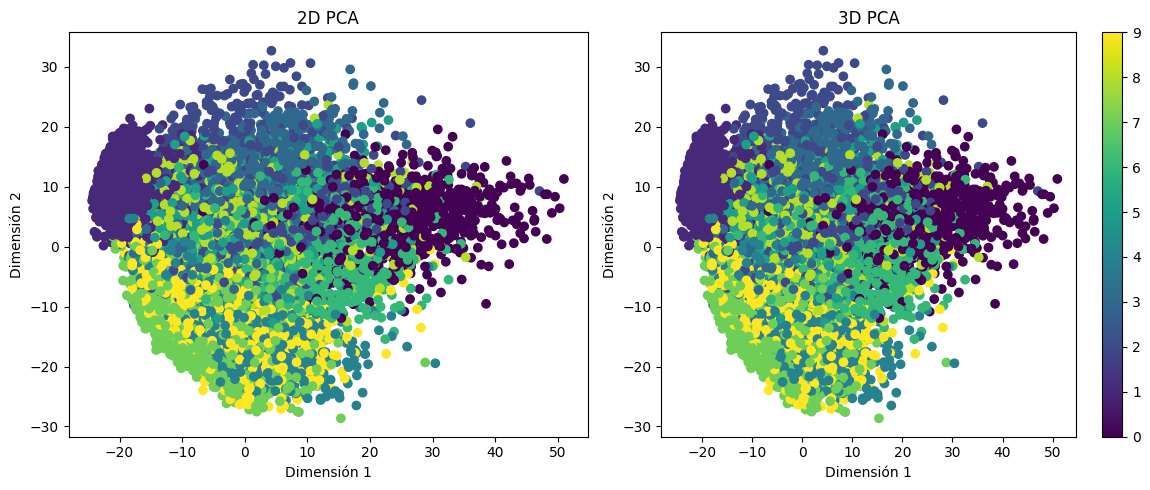

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels)
axes[0].set_title('2D PCA')
axes[0].set_xlabel('Dimensión 1')
axes[0].set_ylabel('Dimensión 2')

scatter = axes[1].scatter(latent_3d[:, 0], latent_3d[:, 1], c=labels)
axes[1].set_title('3D PCA')
axes[1].set_xlabel('Dimensión 1')
axes[1].set_ylabel('Dimensión 2')
fig.colorbar(scatter)

plt.tight_layout()
plt.show()

Se observa generalmente que nuestro espacio latente distingue, a pesar del ruido, bastante bien los diversos números.